# Mixture Models

We are given a set of 200 data points which appear to come from a mixture of Gaussian distributions. Objective is to find the coefficients of the mixture model.

Examples of PyMC3 usage with Hierarchical models.

* [PyMC3 documentation for Mixture](https://docs.pymc.io/api/distributions/mixture.html) -- shows multiple strategies for defining mixture models with PyMC3.
* [Dirichlet Process Mixture for Density Estimation](https://docs.pymc.io/notebooks/dp_mix.html) -- similar to the example in the course.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

Data is provided as part of the course, it may not be publicly available outside the course or after the course. We maintain a local copy to maintain code reproducibility.

Findings from the density plot:
* It seems to be a mixture of 2 Normal distributions, one centered at -2.5 and another centered around +1.25.

In [3]:
mixture_df = pd.read_csv("mixture.csv", header=None, names=["V0"])
mixture_df.head()

,V0
0,-2.266175
1,0.883431
2,1.000343
3,1.019266
4,-3.222235


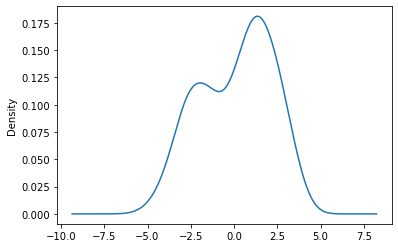

In [4]:
_ = mixture_df["V0"].plot.density()

## Define Model

__NOTE__: The theano setting below disables some error checking on the CLANG C++ compiler on MacOS, which prevents the model from compiling. The g++ compiler on Linux does not have this problem (apparently).

The `cores=1` setting on `pm.sample()` is also caused by a PyMC3 bug. See [this PyMC3 discourse](https://discourse.pymc.io/t/attributeerror-cant-pickle-local-object-mixture-comp-dist-random-wrapper-locals-wrapped-random/4619/4) for a fuller discussion.

In [5]:
import theano

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [6]:
y = mixture_df["V0"].values
y.shape

(200,)

In [7]:
model_1 = pm.Model()
with model_1:
    mu1 = pm.Normal("mu1", mu=-1.0, sigma=1e2)
    mu2 = pm.Normal("mu2", mu=1.0, sigma=1e2)
    prec = pm.InverseGamma("prec", alpha=0.5, beta=0.5)
    sig = pm.math.sqrt(prec)

    omega = pm.Dirichlet("omega", a=np.array([1, 1]), shape=2)

    z1 = pm.Normal.dist(mu=mu1, sigma=sig)
    z2 = pm.Normal.dist(mu=mu2, sigma=sig)
    
    y_obs = pm.Mixture("y_obs", w=omega, comp_dists=[z1, z2], observed=y)
    
    
    trace_1 = pm.sample(5000, tune=1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [omega, prec, mu2, mu1]
Sampling chain 1, 0 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 756.34it/s]


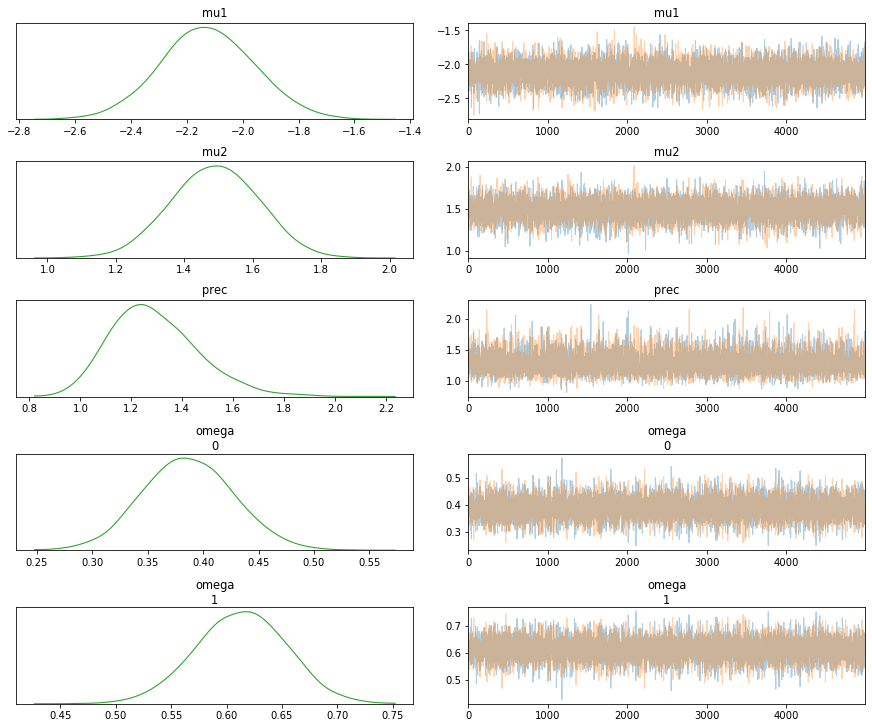

In [8]:
_ = pm.traceplot(trace_1, combined=True, compact=False)

In [9]:
pm.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu1,-2.126,0.167,-2.447,-1.818,0.002,0.001,9423.0,9423.0,9443.0,7358.0,1.0
mu2,1.489,0.127,1.259,1.729,0.001,0.001,8282.0,8282.0,8314.0,7308.0,1.0
prec,1.294,0.172,1.003,1.628,0.002,0.001,7700.0,7318.0,8273.0,7159.0,1.0
omega[0],0.387,0.040,0.312,0.463,0.000,0.000,9302.0,9302.0,9291.0,7457.0,1.0
omega[1],0.613,0.040,0.537,0.688,0.000,0.000,9302.0,9245.0,9291.0,7457.0,1.0


## Findings

* Mixture appears to be composed of 2 Gaussian distributions
* First Distribution is `Normal(mu=-2.127, sigma=0.167)`
* Second Distribution is `Normal(mu=1.490, sigma=0.127)`
* Data is `0.387 * Dist1 + 0.613 * Dist2`